<a href="https://colab.research.google.com/github/Dhanyabahadur/project_notebooks/blob/main/sd%2Bgrounding_dino%2Bsam%2Bcanny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q diffusers accelerate segment_anything transformers

In [2]:
!pip install gradio

In [3]:
!pip install supervision==0.12.0

  Using cached supervision-0.12.0-py3-none-any.whl (48 kB)
  Attempting uninstall: supervision
    Found existing installation: supervision 0.4.0
    Uninstalling supervision-0.4.0:
      Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.12.0 which is incompatible.


In [ ]:
# !pip install groundingdino

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from typing import List
from PIL import Image
from skimage import measure
import cv2
from google.colab.patches import cv2_imshow

import torch
import transformers
import accelerate
import gradio as gr

from diffusers import ControlNetModel, StableDiffusionControlNetInpaintPipeline
from diffusers.utils import load_image, make_image_grid
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

import sys
sys.path.append("..")

HOME = os.getcwd()
print("HOME: ", HOME)

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


HOME:  /content


In [5]:
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
# %cd {HOME}/GroundingDINO
# !git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
# !pip install -e .

In [6]:
!mkdir -p {HOME}/weights
%cd {HOME}
!git clone https://github.com/facebookresearch/segment-anything.git

%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

%cd {HOME}

/content
fatal: destination path 'segment-anything' already exists and is not an empty directory.
/content/weights
/content/weights
/content


In [7]:
!git clone https://github.com/IDEA-Research/GroundingDINO
%cd /content/GroundingDINO
!pip install -e .

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
  Using cached supervision-0.4.0-py3-none-any.whl (25 kB)
  Attempting uninstall: supervision
    Found existing installation: supervision 0.12.0
    Uninstalling supervision-0.12.0:
      Successfully uninstalled supervision-0.12.0
  Attempting uninstall: groundingdino
    Found existing installation: groundingdino 0.1.0
    Uninstalling groundingdino-0.1.0:
      Successfully uninstalled groundingdino-0.1.0
  Running setup.py develop for groundingdino


In [8]:
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device is: CUDA") if torch.cuda.is_available else print("Device is: CPU")

/content/weights/sam_vit_h_4b8939.pth ; exist: True
Device is: CUDA


In [9]:
GROUNDING_DINO_CONFIG_PATH = '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
GROUNDING_DINO_CHECKPOINT_PATH = '/content/weights/groundingdino_swint_ogc.pth'

In [10]:
from groundingdino.util.inference import Model
GD_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
# upload the image in content before running this block
IMAGE_PATH = f"/content/hPZQhuc.jpeg"
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_original = image_bgr

image_bgr = cv2.resize(image_bgr, (512, 512))
image_rgb = cv2.resize(image_rgb, (512, 512))
image_original = cv2.resize(image_original, (512, 512))

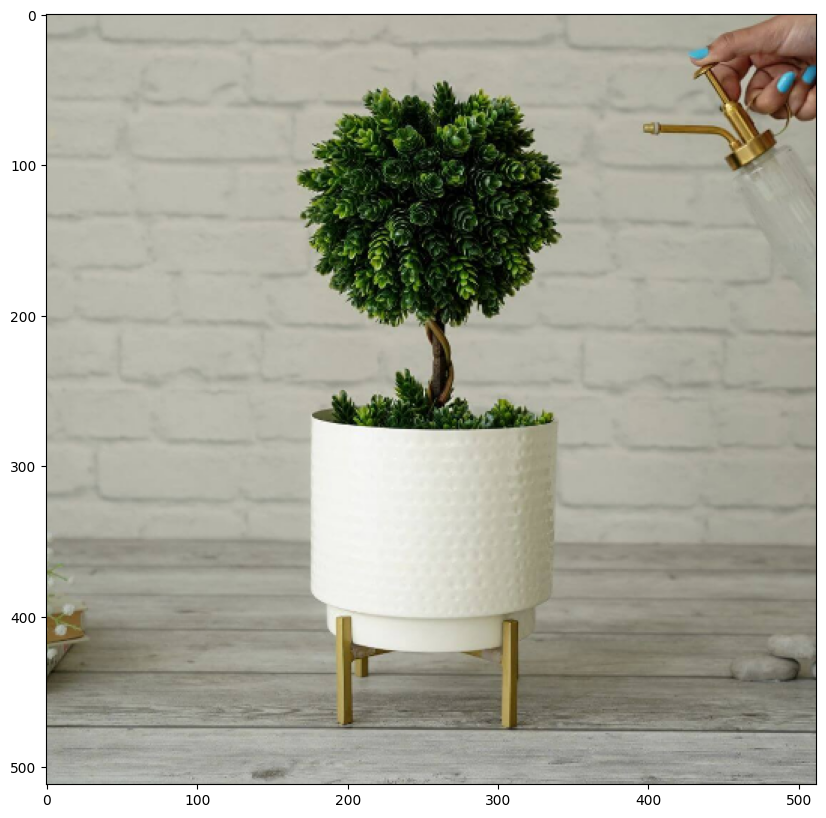

In [12]:
import supervision as sv
sv.plot_image(image_bgr)

In [13]:
# detect objects
CLASSES = ['pot stand','plant pot', 'tree']
detections = GD_model.predict_with_classes(
    image = image_rgb,
    classes = CLASSES,
    box_threshold=0.35,
    text_threshold=0.25
)

print(detections)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Detections(xyxy=array([[165.65817 ,  43.066696, 344.34598 , 271.2083  ],
       [173.20563 , 257.59277 , 342.14392 , 476.61108 ],
       [173.60832 , 259.52606 , 341.8056  , 422.6891  ]], dtype=float32), class_id=array([2, 0, 1]), confidence=array([0.6553989, 0.421581 , 0.4650727], dtype=float32), tracker_id=None)


In [14]:
print(detections.xyxy, type(detections.xyxy))
detected_boxes = detections.xyxy
class_id = detections.class_id
print(class_id)

[[165.65817   43.066696 344.34598  271.2083  ]
 [173.20563  257.59277  342.14392  476.61108 ]
 [173.60832  259.52606  341.8056   422.6891  ]] <class 'numpy.ndarray'>
[2 0 1]


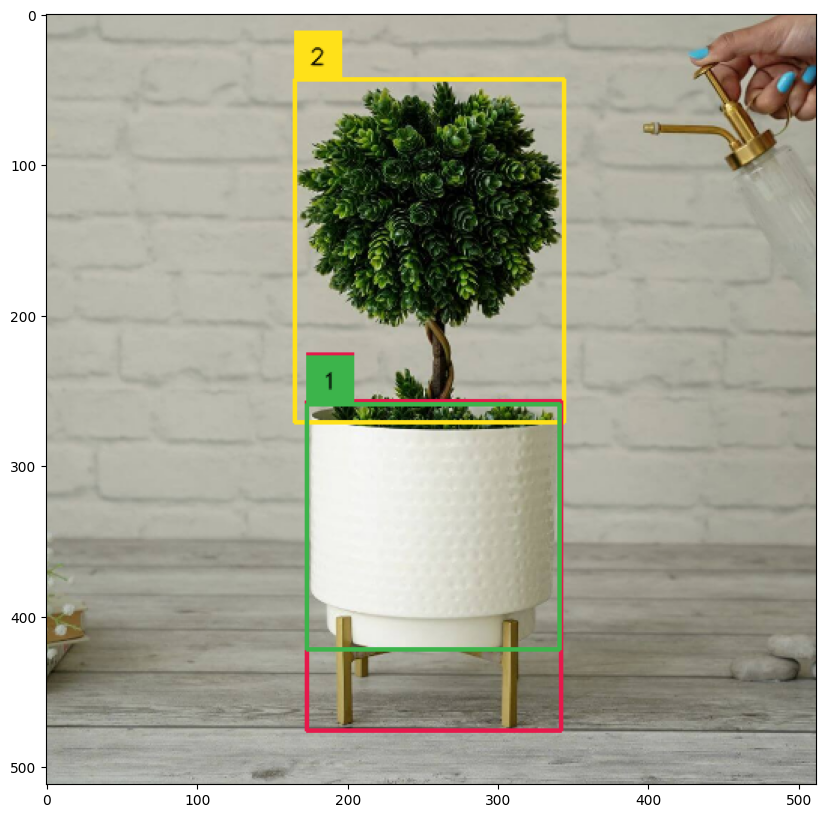

In [15]:
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=False, labels=[class_id])
sv.plot_image(annotated_frame)

In [16]:
# load ControlNet
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, variant="fp16")

# pass ControlNet to the pipeline
sd_pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
).to(device)


vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [36]:
# IMAGE_PATH = f"/content/hPZQhuc.jpeg"
# canny = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
# canny = cv2.Canny(canny, 127, 255)
# cv2.imwrite('canny_image.jpeg', canny)
# #cv2_imshow(canny)

In [17]:
MODEL_TYPE = "vit_h"

IMAGE_PATH = f"{HOME}/hPZQhuc.jpeg"

IMAGE_NAME = IMAGE_PATH.split("/")[-1]

sam = sam_model_registry[MODEL_TYPE](checkpoint = SAM_CHECKPOINT_PATH)
sam.to(device)
predictor = SamPredictor(sam)

In [43]:
detected_boxes

array([[165.65817 ,  43.066696, 344.34598 , 271.2083  ],
       [173.20563 , 257.59277 , 342.14392 , 476.61108 ],
       [173.60832 , 259.52606 , 341.8056  , 422.6891  ]], dtype=float32)

In [49]:
import numpy as np

# Define the 2D array
array = np.array([[165.65817 ,  43.066696, 344.34598 , 271.2083  ],
                  [173.20563 , 257.59277 , 342.14392 , 476.61108 ],
                  [173.60832 , 259.52606 , 341.8056  , 422.6891  ]], dtype=np.float32)

# Function to return rows as comma-separated arrays
def get_rows_as_comma_separated_arrays(array):
    rows = []
    for row in array:
        print("row :- ", row)
        row_as_list = row.tolist()
        print("row_as_list :- ", row_as_list)
        #row_as_string = ", ".join(map(str, row_as_list))
        rows.append(row_as_list)
    return rows

# Get and print each row as a comma-separated array
comma_separated_rows = get_rows_as_comma_separated_arrays(array)
for row in comma_separated_rows:
    print(row)

row :-  [165.65817   43.066696 344.34598  271.2083  ]
row_as_list :-  [165.65817260742188, 43.06669616699219, 344.3459777832031, 271.20831298828125]
row :-  [173.20563 257.59277 342.14392 476.61108]
row_as_list :-  [173.20562744140625, 257.5927734375, 342.1439208984375, 476.611083984375]
row :-  [173.60832 259.52606 341.8056  422.6891 ]
row_as_list :-  [173.6083221435547, 259.52606201171875, 341.80560302734375, 422.6890869140625]
[165.65817260742188, 43.06669616699219, 344.3459777832031, 271.20831298828125]
[173.20562744140625, 257.5927734375, 342.1439208984375, 476.611083984375]
[173.6083221435547, 259.52606201171875, 341.80560302734375, 422.6890869140625]


In [46]:
comma_separated_rows

['165.65817260742188, 43.06669616699219, 344.3459777832031, 271.20831298828125',
 '173.20562744140625, 257.5927734375, 342.1439208984375, 476.611083984375',
 '173.6083221435547, 259.52606201171875, 341.80560302734375, 422.6890869140625']

In [58]:
# sam grounding dino
#mask_annotator = sv.MaskAnnotator()
mask_predictor = predictor
segmented_mask = []
counter = 0
for mybox in detected_boxes:
  print(mybox)
  mybox = np.array(mybox)
  print((mybox))
  print(mybox.shape)
  #coords = np.asarray(list(mybox.tolist()))
  coords = np.array([mybox])
  print(coords)
  print(type(coords))
  mask_predictor.set_image(image_rgb)
  masks, scores, logits = mask_predictor.predict(
      point_coords = None,
      point_labels=None,
      box=mybox,
      multimask_output=False
  )

  segmented_mask.append(masks)
  print(len(masks), masks.shape)

  #sys.exit()
  # plot masks on image using supervision
  detections = sv.Detections(
      xyxy = coords,
      #mask=masks
  )

  detections = detections[detections.area == np.max(detections.area)]
  print(CLASSES[class_id[counter]])

  annotated_image = box_annotator.annotate(scene=image_original.copy(), detections=detections, skip_label=False, labels=[CLASSES[class_id[counter]]])
  #annotated_image = mask_annotator.annotate(scene=annotated_image.copy(), detections=detections)
  image_original = annotated_image

  counter+= 1

[165.65817   43.066696 344.34598  271.2083  ]
[165.65817   43.066696 344.34598  271.2083  ]
(4,)
[[165.65817   43.066696 344.34598  271.2083  ]]
<class 'numpy.ndarray'>
1 (1, 512, 512)
tree
[173.20563 257.59277 342.14392 476.61108]
[173.20563 257.59277 342.14392 476.61108]
(4,)
[[173.20563 257.59277 342.14392 476.61108]]
<class 'numpy.ndarray'>
1 (1, 512, 512)
pot stand
[173.60832 259.52606 341.8056  422.6891 ]
[173.60832 259.52606 341.8056  422.6891 ]
(4,)
[[173.60832 259.52606 341.8056  422.6891 ]]
<class 'numpy.ndarray'>
1 (1, 512, 512)
plant pot


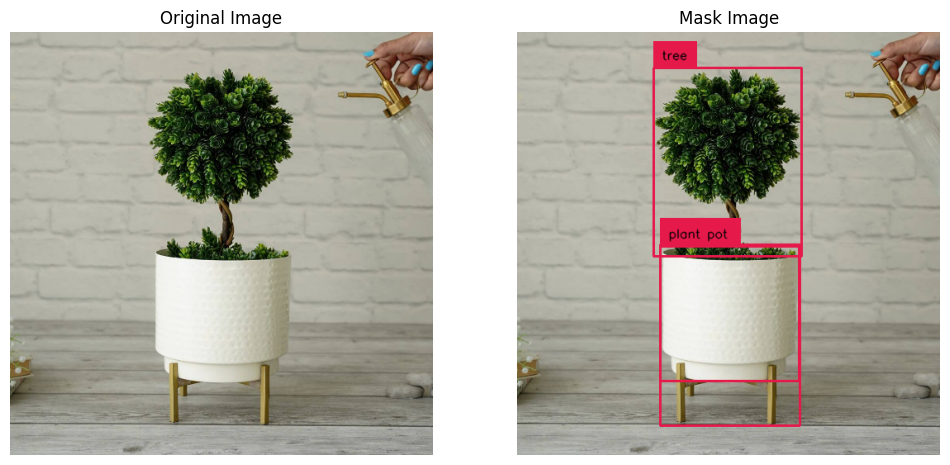

In [59]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1,2),
    titles=['Original Image', 'Mask Image']
)

In [60]:
print(len(segmented_mask), type(segmented_mask[0]), segmented_mask[0].shape)

for i in range(len(segmented_mask)):

  segmented_mask[i] = segmented_mask[i].transpose(1,2,0)
  segmented_mask[i] = np.array(segmented_mask[i]*255).astype('uint8')
  segmented_mask[i] = cv2.cvtColor(segmented_mask[i], cv2.COLOR_GRAY2BGR)

print(segmented_mask[0].shape)

3 <class 'numpy.ndarray'> (1, 512, 512)
(512, 512, 3)


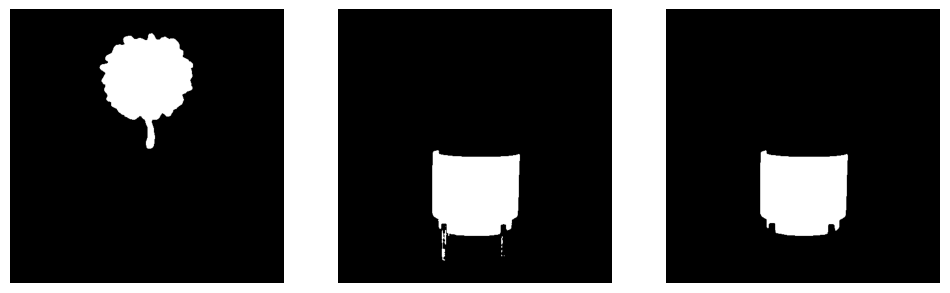

In [61]:
sv.plot_images_grid(
    images=segmented_mask,
    grid_size=(1, len(segmented_mask)),
)

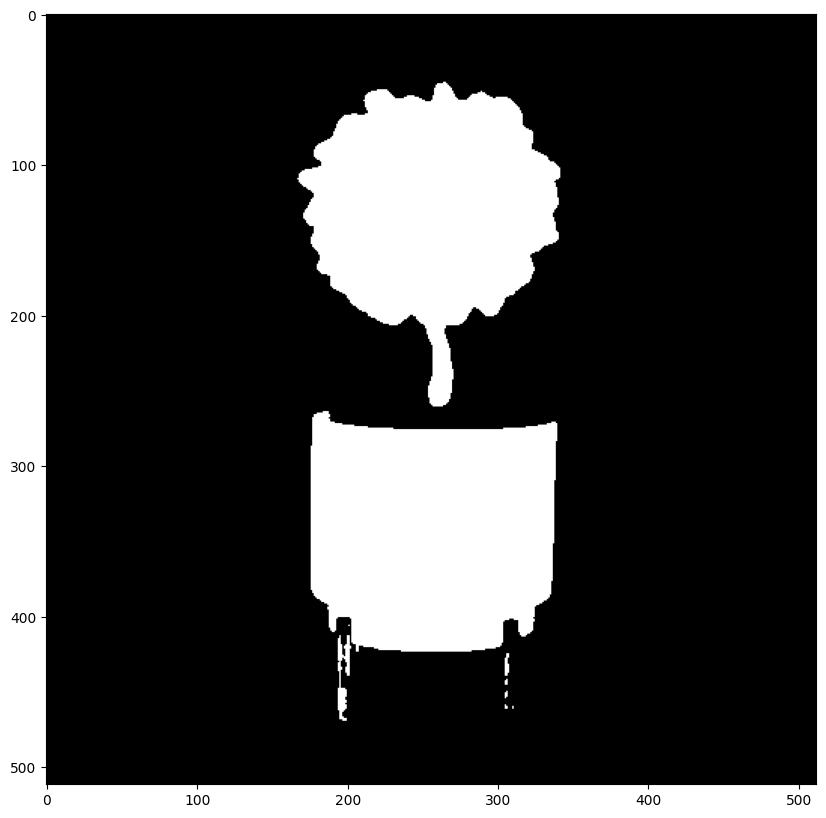

In [62]:
segmented_image = segmented_mask[0]

for i in range(len(segmented_mask)):
  try:
    segmented_image = cv2.bitwise_or(segmented_image, segmented_mask[i+1])
  except:
    pass

sv.plot_image(segmented_image)

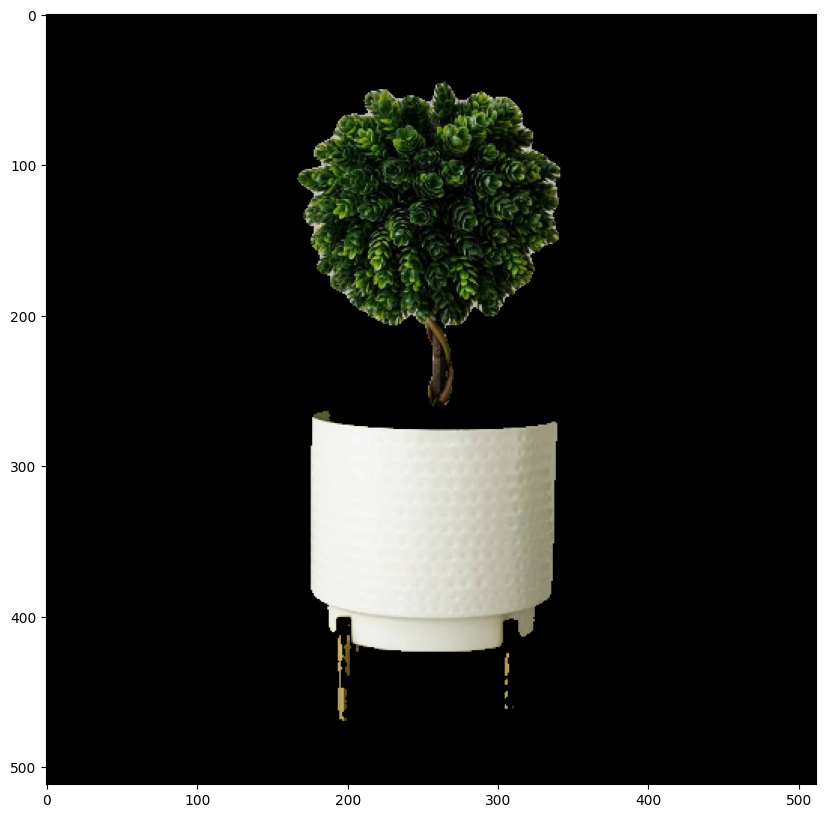

In [63]:
segmented_image = cv2.bitwise_and(segmented_image, image_bgr)
sv.plot_image(segmented_image)

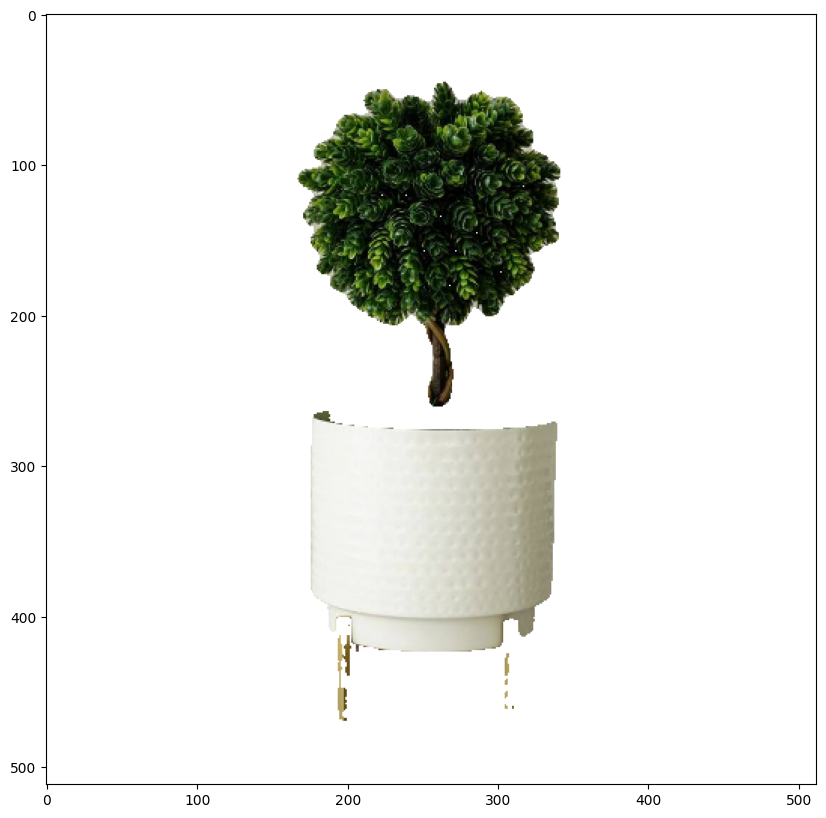

In [64]:
segmented_image[np.where((segmented_image == [0,0,0]).all(axis=2))] = [255, 255, 255]
sv.plot_image(segmented_image)

In [67]:
#IMAGE_PATH = f"/content/hPZQhuc.jpeg"
# canny = cv2.imread(segmented_image)
# canny = cv2.Canny(canny, 127, 255)
cv2.imwrite('/content/segmented_image.jpeg', segmented_image)
#cv2_imshow(canny)

True

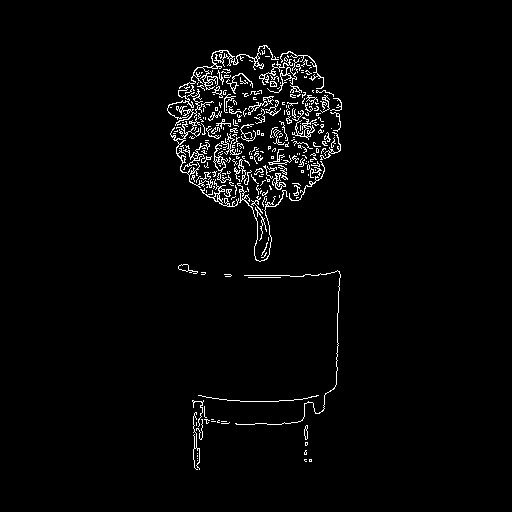

In [82]:
PATH = f"/content/segmented_image.jpeg"
canny = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
canny = cv2.Canny(canny, 127, 255)
cv2.imwrite('/content/canny_image.jpeg', canny)
cv2_imshow(canny)

In [83]:

selected_pixels = []
with gr.Blocks() as demo:
  with gr.Row():
    input_img = gr.Image(label="Input")
    mask_img = gr.Image(label="Mask")
    control_img = gr.Image(label="Control")
    output_img = gr.Image(label="Output")

  with gr.Row():
    prompt_text = gr.Textbox(lines=1, label="Prompt")

  with gr.Row():
    submit = gr.Button("Submit")

  def generate_mask(image, evt: gr.SelectData):
    selected_pixels.append(evt.index)

    predictor.set_image(image)

    input_points = np.array(selected_pixels)
    input_labels = np.ones(input_points.shape[0])

    mask, _, _ = predictor.predict(
        point_coords = input_points,
        point_labels = input_labels,
        multimask_output = False
    )
    mask = np.logical_not(mask)
    mask = Image.fromarray(mask[0, :, :])
    return mask


  input_img.select(generate_mask, [input_img], [mask_img])

  def inpaint(image, mask, control, prompt):
    image = Image.fromarray(image)
    mask = Image.fromarray(mask)
    control = Image.fromarray(control)

    image = image.resize((512, 512))
    mask = mask.resize((512, 512))
    control = control.resize((512, 512))

    output = sd_pipe(prompt=prompt, image=image, mask_image = mask, control_image=control).images[0]

    return output

  submit.click(inpaint, inputs=[input_img, mask_img, control_img, prompt_text], outputs=[output_img])

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f47158843d98298192.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f47158843d98298192.gradio.live
